In [1]:
using CSV, DataFrames
using DelaunayTriangulation
using StaticArrays
using LinearAlgebra
using CairoMakie
using Statistics

# Calcule la normale d'un triangle 3D
function normale(tri_pts)
    p1, p2, p3 = tri_pts
    v1, v2 = SVector(p2 .- p1), SVector(p3 .- p1)
    n = cross(v1, v2)
    return norm(n) == 0 ? n : n / norm(n)
end

# Calcule la pente en mrad entre deux normales
function angle_entre_normales(n1, n2)
    teta = acos(clamp(dot(n1, n2), -1.0, 1.0))
    return teta * 1000  # mrad
end

function aire(p1, p2, p3)
    return 0.5 * abs((p2[1] - p1[1]) * (p3[2] - p1[2]) - (p2[2] - p1[2]) * (p3[1] - p1[1]))
end

function bon_tiangle(p1, p2, p3, aire_limite; ratio_limite=3) # Rapport entre plus grand et plus court côté
    l1 = norm(p2 .- p1)
    l2 = norm(p3 .- p2)
    l3 = norm(p1 .- p3)
    a = aire(p1, p2, p3)
    return (((max(l1, l2, l3) / min(l1, l2, l3)) < ratio_limite) && (a > aire_limite))
end


bon_tiangle (generic function with 1 method)

In [2]:
# # Chargement des points depuis un fichier CSV
# df = CSV.read("14111.csv", DataFrame, header=false, delim=';')
# rename!(df, [:x, :y, :z])
# points = [(df.x[i], df.y[i], df.z[i]) for i in 1:nrow(df)]
# points_xy = [(p[1], p[2]) for p in points]

pts_tmps = []
open("M2TIR_CB2_14111_15057_final.txt", "r") do file
    in_tol_surf_prof = false

    for line in eachline(file)
        line = strip(line)

        if startswith(line, "TOL_SURF_PROF")
            in_tol_surf_prof = true
            continue
        elseif startswith(line, "END") && in_tol_surf_prof
            in_tol_surf_prof = false
            continue
        end

        if in_tol_surf_prof && startswith(line, "PROBE")
            values = parse.(Float64, split(line, ',')[2:end])
            push!(pts_tmps, (x = values[2], y = values[3], z = values[end]))
        end
    end
end

df = DataFrame(pts_tmps)


points = [(df.x[i], df.y[i], df.z[i]) for i in 1:nrow(df)]
points_xy = [(p[1], p[2]) for p in points]

533-element Vector{Tuple{Float64, Float64}}:
 (1389.97, -450.414)
 (1385.111, -449.825)
 (1380.237, -449.273)
 (1375.356, -448.729)
 (1370.482, -448.186)
 (1321.171, -447.482)
 (1326.025, -448.025)
 (1330.896, -448.568)
 (1335.775, -449.11)
 (1340.654, -449.653)
 ⋮
 (1368.172, -557.826)
 (1373.051, -558.366)
 (1377.928, -558.906)
 (1382.81, -559.447)
 (1333.517, -558.757)
 (1328.621, -558.214)
 (1323.739, -557.673)
 (1318.858, -557.131)
 (1313.977, -556.589)

In [3]:

# Triangulation de Delaunay sur le plan XY
#maillage = triangulate(xy; delete_ghosts = true)
maillage = triangulate(points_xy)

aires = [aire(points[tri[1]],points[tri[2]],points[tri[3]]) for tri in each_solid_triangle(maillage)]
aire_moy = mean(aires)
aire_limite = aire_moy * .1

1.1455337395752898

In [4]:
angles_aretes = Dict{Tuple{Int, Int}, Float64}()
for arete in each_solid_edge(maillage)
    s1, s2 = get_adjacent(maillage, arete[1], arete[2]), get_adjacent(maillage, arete[2], arete[1]) # Sommets de part et d'autre de l'arete (-1 si pas de sommet)
    #println(bon_tiangle(points[arete[1]], points[arete[2]], points[s1], aire_limite))
    if s1 != -1 && s2 != -1 && bon_tiangle(points[arete[1]], points[arete[2]], points[s1], aire_limite) && bon_tiangle(points[arete[2]], points[arete[1]], points[s2], aire_limite)
        n1 = normale((points[arete[1]], points[arete[2]], points[s1]))
        n2 = normale((points[arete[2]], points[arete[1]], points[s2]))
        angle = angle_entre_normales(n1, n2)
        push!(angles_aretes, arete => angle)
    else
        push!(angles_aretes, arete => -1)
    end
end
angles_aretes

Dict{Tuple{Int64, Int64}, Float64} with 1568 entries:
  (270, 293) => 0.0
  (516, 531) => 7.45058e-5
  (487, 488) => 0.210654
  (485, 459) => 0.0
  (223, 224) => 0.0
  (387, 369) => 0.292474
  (429, 428) => 0.21063
  (199, 219) => 0.0
  (204, 164) => 0.0
  (473, 474) => 0.210605
  (178, 179) => 0.000629739
  (187, 230) => 1.42534
  (31, 16)   => 0.0
  (115, 102) => 0.203955
  (455, 454) => 0.00180483
  (504, 503) => 0.210654
  (336, 337) => 0.00123248
  (345, 344) => 0.0017212
  (233, 134) => -1.0
  ⋮          => ⋮

In [5]:
#min_angle, max_angle = extrema(values(angles_aretes))
max_angle = maximum(values(angles_aretes))
min_angle = minimum(a for a in values(angles_aretes) if a!=-1)
#min_angle = median(values(angles_aretes))
#min_angle = .8 * max_angle
#min_angle = 0
min_angle, max_angle

(0.0, 1.895004208228633)

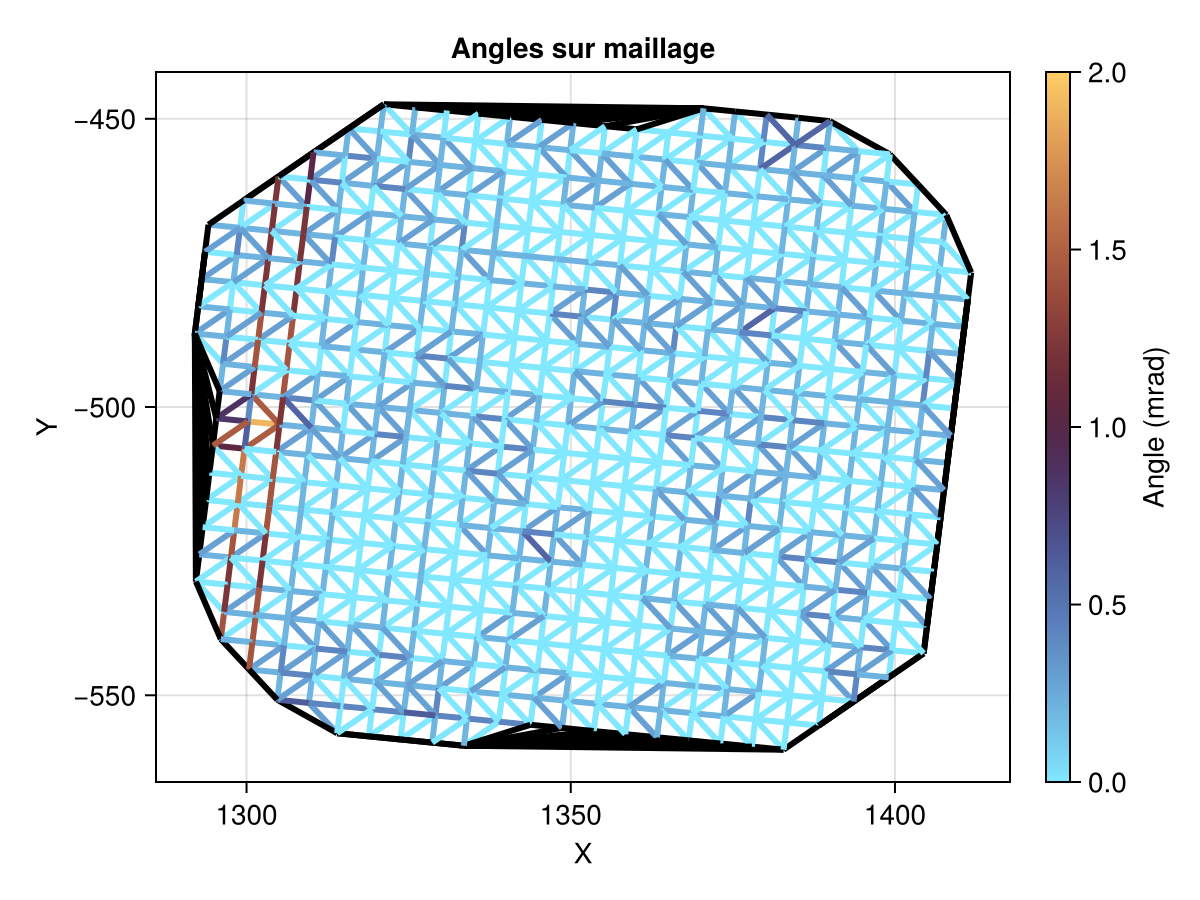

In [7]:
fig = Figure()
ax = Axis(fig[1, 1], title="Angles sur maillage", xlabel="X", ylabel="Y")
#hot = reverse(:hot)

min_tmp = 0
max_tmp = 2

for (arete, angle) in angles_aretes
    p1, p2 = points[arete[1]], points[arete[2]]
    if angle != -1
        color = reverse(cgrad(:managua))[(angle - min_tmp) / (max_tmp - min_tmp)]
    else
        color = "black"
    end
    lines!(ax, [p1[1], p2[1]], [p1[2], p2[2]], color=color, linewidth=3)
end

# for (arete, angle) in angles_aretes
#     if angle > min_angle
#         p1, p2 = points[arete[1]], points[arete[2]]
#         color = cgrad(:viridis)[(angle - min_angle) / (max_angle - min_angle)]
#         lines!(ax, [p1[1], p2[1]], [p1[2], p2[2]], color=color, linewidth=3)
#     end
# end

# Ajouter une barre de couleur
Colorbar(fig[1, 2], colormap=reverse(cgrad(:managua)), label="Angle (mrad)", limits=(min_tmp, max_tmp))

# Afficher la figure
fig